In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/MyDrive/d2p/inventory_data.csv')

In [4]:
df.head()

,timestamp,product_id,estimated_stock_pct,category,unit_price,quantity,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,kitchen,11.19,3.0,-0.02885
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,vegetables,1.49,3.0,-0.02885
2,2022-03-01 09:00:00,0ddc2379-adba-4fb0-aa97-19fcafc738a1,0.35,fruit,3.99,3.0,-0.02885
3,2022-03-01 09:00:00,146d5e4d-992a-4db7-904d-b8af359b80a7,0.48,baking,8.19,1.0,-0.02885
4,2022-03-01 09:00:00,14736243-d346-438f-9535-d80fcb9f3882,0.67,fruit,1.49,6.0,-0.02885


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            10845 non-null  object 
 1   product_id           10845 non-null  object 
 2   estimated_stock_pct  10845 non-null  float64
 3   category             10845 non-null  object 
 4   unit_price           10845 non-null  float64
 5   quantity             3067 non-null   float64
 6   temperature          10845 non-null  float64
dtypes: float64(4), object(3)
memory usage: 593.2+ KB


In [6]:
df['category'].nunique()

22

In [7]:
df['category'].unique()

array(['kitchen', 'vegetables', 'fruit', 'baking', 'dairy',
       'packaged foods', 'baked goods', 'refrigerated items', 'meat',
       'personal care', 'beverages', 'baby products', 'pets',
       'condiments and sauces', 'frozen', 'cheese', 'canned foods',
       'seafood', 'medicine', 'snacks', 'cleaning products',
       'spices and herbs'], dtype=object)

In [8]:
target = 'estimated_stock_pct'
num_cols = [col for col in df.columns if df[col].dtype != 'O' and col != target]
cat_cols = [col for col in df.columns if df[col].dtype == 'O' and col != target]

print(len(num_cols), len(cat_cols))
print(num_cols)
print(cat_cols)

3 3
['unit_price', 'quantity', 'temperature']
['timestamp', 'product_id', 'category']


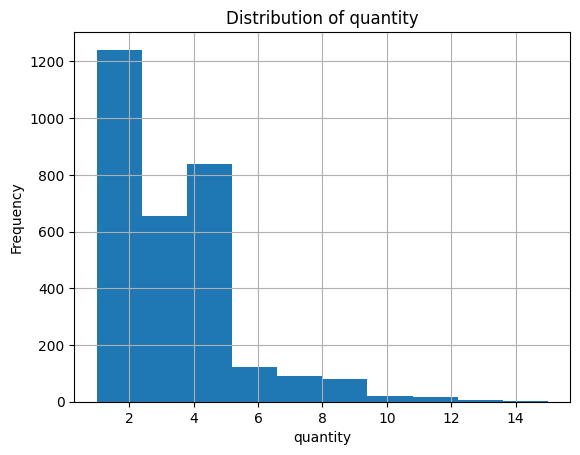

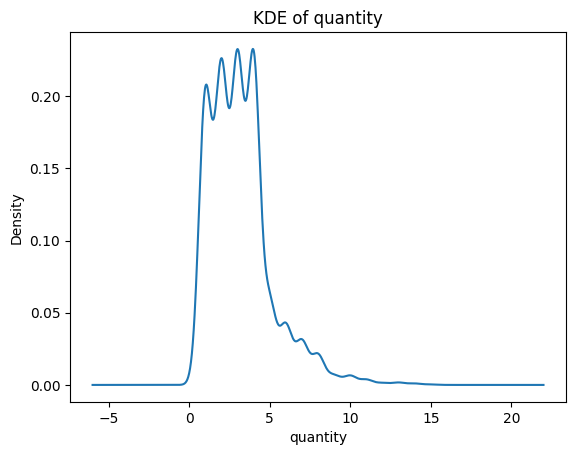

In [9]:
# Histogram for visualizing the distribution
df['quantity'].hist(bins=10)
plt.xlabel('quantity')
plt.ylabel('Frequency')
plt.title('Distribution of quantity')
plt.show()

# Kernel Density Estimation (KDE) plot for smoother distribution
df['quantity'].plot(kind='kde')
plt.xlabel('quantity')
plt.title('KDE of quantity')
plt.show()

In [10]:
# Fill missing values with median due to right-skewed distribution
df['quantity'].fillna(df['quantity'].median(), inplace=True)

In [11]:
# Function to create lagged features
def create_lagged_features(df, target_column, lags):
    for lag in lags:
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    return df

In [12]:
# Define the lags (e.g., previous 1, 2, 3, 6, 12, 24 hours)
lags = [1, 2, 3, 6, 12, 24]

# Create lagged features
df_lagged = create_lagged_features(df.copy(), 'estimated_stock_pct', lags)

In [13]:
# Perform train-test split (last 2 days for testing, rest for training)
X_train = df_lagged[df_lagged['timestamp'] < '2022-03-06']
X_test = df_lagged[df_lagged['timestamp'] >= '2022-03-06']

In [14]:
y_train = X_train[target]
y_test = X_test[target]

In [15]:
X_test = X_test.drop([target,'product_id'], axis=1)

In [16]:
X_train = X_train.drop([target,'product_id'], axis=1)
X_train.head()

,timestamp,category,unit_price,quantity,temperature,estimated_stock_pct_lag_1,estimated_stock_pct_lag_2,estimated_stock_pct_lag_3,estimated_stock_pct_lag_6,estimated_stock_pct_lag_12,estimated_stock_pct_lag_24
0,2022-03-01 09:00:00,kitchen,11.19,3.0,-0.02885,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-01 09:00:00,vegetables,1.49,3.0,-0.02885,0.89,NaN,NaN,NaN,NaN,NaN
2,2022-03-01 09:00:00,fruit,3.99,3.0,-0.02885,0.14,0.89,NaN,NaN,NaN,NaN
3,2022-03-01 09:00:00,baking,8.19,1.0,-0.02885,0.35,0.14,0.89,NaN,NaN,NaN
4,2022-03-01 09:00:00,fruit,1.49,6.0,-0.02885,0.48,0.35,0.14,NaN,NaN,NaN


In [17]:
# Category grouping dictionary
category_grouping = {
    'dairy': 'Dairy Products',
    'cheese': 'Dairy Products',
    'baking': 'Dairy Products',
    'baked goods': 'Packaged Goods',
    'fruit': 'Fresh Produce',
    'vegetables': 'Fresh Produce',
    'packaged foods': 'Packaged Goods',
    'canned foods': 'Packaged Goods',
    'snacks': 'Packaged Goods',
    'frozen': 'Frozen and Refrigerated',
    'refrigerated items': 'Frozen and Refrigerated',
    'meat': 'Frozen and Refrigerated',
    'seafood': 'Frozen and Refrigerated',
    'condiments and sauces': 'Condiments and Spices',
    'spices and herbs': 'Condiments and Spices',
    'cleaning products': 'Household and Personal Care',
    'personal care': 'Household and Personal Care',
    'medicine': 'Household and Personal Care',
    'kitchen': 'Household and Personal Care',
    'beverages': 'Packaged Goods',
    'baby products': 'Packaged Goods',
    'pets': 'Household and Personal Care'
}

In [18]:
X_train['grouped_category'] = X_train['category'].replace(category_grouping)
X_test['grouped_category'] = X_test['category'].replace(category_grouping)

In [19]:
category_dummies_train = pd.get_dummies(X_train['grouped_category'], prefix='category')
category_dummies_test = pd.get_dummies(X_test['grouped_category'], prefix='category')

In [20]:
X_train = pd.concat([X_train, category_dummies_train], axis=1)
X_test = pd.concat([X_test, category_dummies_test], axis=1)

In [21]:
X_train.head()

,timestamp,category,unit_price,quantity,temperature,estimated_stock_pct_lag_1,estimated_stock_pct_lag_2,estimated_stock_pct_lag_3,estimated_stock_pct_lag_6,estimated_stock_pct_lag_12,estimated_stock_pct_lag_24,grouped_category,category_Condiments and Spices,category_Dairy Products,category_Fresh Produce,category_Frozen and Refrigerated,category_Household and Personal Care,category_Packaged Goods
0,2022-03-01 09:00:00,kitchen,11.19,3.0,-0.02885,NaN,NaN,NaN,NaN,NaN,NaN,Household and Personal Care,False,False,False,False,True,False
1,2022-03-01 09:00:00,vegetables,1.49,3.0,-0.02885,0.89,NaN,NaN,NaN,NaN,NaN,Fresh Produce,False,False,True,False,False,False
2,2022-03-01 09:00:00,fruit,3.99,3.0,-0.02885,0.14,0.89,NaN,NaN,NaN,NaN,Fresh Produce,False,False,True,False,False,False
3,2022-03-01 09:00:00,baking,8.19,1.0,-0.02885,0.35,0.14,0.89,NaN,NaN,NaN,Dairy Products,False,True,False,False,False,False
4,2022-03-01 09:00:00,fruit,1.49,6.0,-0.02885,0.48,0.35,0.14,NaN,NaN,NaN,Fresh Produce,False,False,True,False,False,False


In [22]:
# List of boolean columns to convert
bool_columns = ['category_Condiments and Spices', 'category_Dairy Products', 'category_Fresh Produce',
                'category_Frozen and Refrigerated', 'category_Household and Personal Care', 'category_Packaged Goods']

# Convert boolean columns to 0 or 1
X_train[bool_columns] = X_train[bool_columns].astype(int)
X_test[bool_columns] = X_test[bool_columns].astype(int)

In [23]:
X_test.head()

,timestamp,category,unit_price,quantity,temperature,estimated_stock_pct_lag_1,estimated_stock_pct_lag_2,estimated_stock_pct_lag_3,estimated_stock_pct_lag_6,estimated_stock_pct_lag_12,estimated_stock_pct_lag_24,grouped_category,category_Condiments and Spices,category_Dairy Products,category_Fresh Produce,category_Frozen and Refrigerated,category_Household and Personal Care,category_Packaged Goods
4453,2022-03-06 09:00:00,snacks,1.99,3.0,-1.26566,0.75,0.77,0.20,0.81,0.773333,0.440,Packaged Goods,0,0,0,0,0,1
4454,2022-03-06 09:00:00,meat,16.19,2.0,-1.26566,0.58,0.75,0.77,0.85,0.780000,0.070,Frozen and Refrigerated,0,0,0,1,0,0
4455,2022-03-06 09:00:00,fruit,3.99,3.0,-1.26566,0.69,0.58,0.75,0.51,0.100000,0.265,Fresh Produce,0,0,1,0,0,0
4456,2022-03-06 09:00:00,baking,2.99,3.0,-1.26566,0.38,0.69,0.58,0.20,0.405000,0.200,Dairy Products,0,1,0,0,0,0
4457,2022-03-06 09:00:00,personal care,16.99,3.0,-1.26566,0.78,0.38,0.69,0.77,0.465000,0.460,Household and Personal Care,0,0,0,0,1,0


In [24]:
X_train = X_train.drop(['category', 'grouped_category'], axis=1)
X_test = X_test.drop(['category', 'grouped_category'], axis=1)

## Extract datetime features from timestamp

In [25]:
X_train['timestamp'] = pd.to_datetime(X_train['timestamp'])
X_test['timestamp'] = pd.to_datetime(X_test['timestamp'])

In [26]:
# Training data
X_train['month'] = X_train['timestamp'].dt.month
X_train['day'] = X_train['timestamp'].dt.day
X_train['hour'] = X_train['timestamp'].dt.hour
X_train['day_of_week'] = X_train['timestamp'].dt.dayofweek
X_train['is_weekend'] = (X_train['day_of_week'] >= 5).astype(int)  # Weekend indicator

In [27]:
# Test data
X_test['month'] = X_test['timestamp'].dt.month
X_test['day'] = X_test['timestamp'].dt.day
X_test['hour'] = X_test['timestamp'].dt.hour
X_test['day_of_week'] = X_test['timestamp'].dt.dayofweek
X_test['is_weekend'] = (X_test['day_of_week'] >= 5).astype(int)  # Weekend indicator

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7737 entries, 0 to 9301
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   timestamp                             7737 non-null   datetime64[ns]
 1   unit_price                            7737 non-null   float64       
 2   quantity                              7737 non-null   float64       
 3   temperature                           7737 non-null   float64       
 4   estimated_stock_pct_lag_1             7736 non-null   float64       
 5   estimated_stock_pct_lag_2             7735 non-null   float64       
 6   estimated_stock_pct_lag_3             7734 non-null   float64       
 7   estimated_stock_pct_lag_6             7731 non-null   float64       
 8   estimated_stock_pct_lag_12            7725 non-null   float64       
 9   estimated_stock_pct_lag_24            7713 non-null   float64       
 10  categ

In [29]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3108 entries, 4453 to 10844
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   timestamp                             3108 non-null   datetime64[ns]
 1   unit_price                            3108 non-null   float64       
 2   quantity                              3108 non-null   float64       
 3   temperature                           3108 non-null   float64       
 4   estimated_stock_pct_lag_1             3108 non-null   float64       
 5   estimated_stock_pct_lag_2             3108 non-null   float64       
 6   estimated_stock_pct_lag_3             3108 non-null   float64       
 7   estimated_stock_pct_lag_6             3108 non-null   float64       
 8   estimated_stock_pct_lag_12            3108 non-null   float64       
 9   estimated_stock_pct_lag_24            3108 non-null   float64       
 10  c

In [30]:
X_train = X_train.ffill()

In [31]:
X_train = X_train.bfill()

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7737 entries, 0 to 9301
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   timestamp                             7737 non-null   datetime64[ns]
 1   unit_price                            7737 non-null   float64       
 2   quantity                              7737 non-null   float64       
 3   temperature                           7737 non-null   float64       
 4   estimated_stock_pct_lag_1             7737 non-null   float64       
 5   estimated_stock_pct_lag_2             7737 non-null   float64       
 6   estimated_stock_pct_lag_3             7737 non-null   float64       
 7   estimated_stock_pct_lag_6             7737 non-null   float64       
 8   estimated_stock_pct_lag_12            7737 non-null   float64       
 9   estimated_stock_pct_lag_24            7737 non-null   float64       
 10  categ

In [33]:
X_train = X_train.drop('timestamp', axis=1)
X_test = X_test.drop('timestamp', axis=1)

In [34]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Initialize XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=6)

# Train the model
xgboost_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = xgboost_model.predict(X_test)

In [35]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.2662204314426538


In [36]:
import pickle

# Save the trained model
with open('/content/drive/MyDrive/d2p/xgb_model.pkl', 'wb') as model_file:
    pickle.dump(xgboost_model, model_file)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            10845 non-null  object 
 1   product_id           10845 non-null  object 
 2   estimated_stock_pct  10845 non-null  float64
 3   category             10845 non-null  object 
 4   unit_price           10845 non-null  float64
 5   quantity             10845 non-null  float64
 6   temperature          10845 non-null  float64
dtypes: float64(4), object(3)
memory usage: 593.2+ KB


In [38]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [39]:
def generate_future_features(df, periods=90):
    """
    Generate feature data for future timestamps, accounting for multiple products and categories.
    """
    # Generate future dates
    future_dates = pd.date_range(start=df['timestamp'].max(), periods=periods, freq='H')

    # Get unique product IDs and their categories
    product_info = df[['product_id', 'category']].drop_duplicates().set_index('product_id')

    # Create a DataFrame for future data
    future_data = pd.DataFrame([(date, pid) for date in future_dates for pid in product_info.index],
                               columns=['timestamp', 'product_id'])

    # Add category information
    future_data['category'] = future_data['product_id'].map(product_info['category'])

    # For each product, use the most recent unit price
    last_prices = df.groupby('product_id')['unit_price'].last()
    future_data['unit_price'] = future_data['product_id'].map(last_prices)

    # Use the average historical quantity sold for each product
    avg_quantities = df.groupby('product_id')['quantity'].mean()
    future_data['quantity'] = future_data['product_id'].map(avg_quantities)

    # For temperature, use the average temperature for each hour of the day and month
    temp_avg = df.groupby([df['timestamp'].dt.month, df['timestamp'].dt.hour])['temperature'].mean()
    overall_mean_temp = df['temperature'].mean()

    def get_temperature(row):
        try:
            return temp_avg.loc[row['timestamp'].month, row['timestamp'].hour]
        except KeyError:
            return overall_mean_temp

    future_data['temperature'] = future_data.apply(get_temperature, axis=1)

    # Create lag features for estimated stock percentage
    for lag in [1, 2, 3, 6, 12, 24]:
        col_name = f'estimated_stock_pct_lag_{lag}'

        # Compute the lagged features for the original dataframe if not present
        if col_name not in df.columns:
            df[col_name] = df.groupby('product_id')['estimated_stock_pct'].shift(lag)

        last_stock = df.groupby('product_id')[col_name].last()
        future_data[col_name] = future_data['product_id'].map(last_stock)

    # Add grouped category
    future_data['grouped_category'] = future_data['category'].replace(category_grouping)

    category_dummies_future = pd.get_dummies(future_data['grouped_category'], prefix='category')

    future_data = pd.concat([future_data, category_dummies_future], axis=1)

    future_data[bool_columns] = future_data[bool_columns].astype(int)

    # Create time-based features
    future_data['month'] = future_data['timestamp'].dt.month
    future_data['day'] = future_data['timestamp'].dt.day
    future_data['hour'] = future_data['timestamp'].dt.hour
    future_data['day_of_week'] = future_data['timestamp'].dt.dayofweek
    future_data['is_weekend'] = future_data['day_of_week'].isin([5, 6]).astype(int)

    return future_data

In [40]:
future_data = generate_future_features(df, periods=90)

In [41]:
future_data = future_data.ffill()

In [42]:
future_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   timestamp                             27000 non-null  datetime64[ns]
 1   product_id                            27000 non-null  object        
 2   category                              27000 non-null  object        
 3   unit_price                            27000 non-null  float64       
 4   quantity                              27000 non-null  float64       
 5   temperature                           27000 non-null  float64       
 6   estimated_stock_pct_lag_1             27000 non-null  float64       
 7   estimated_stock_pct_lag_2             27000 non-null  float64       
 8   estimated_stock_pct_lag_3             27000 non-null  float64       
 9   estimated_stock_pct_lag_6             27000 non-null  float64       
 10

In [43]:
future_data.head()

,timestamp,product_id,category,unit_price,quantity,temperature,estimated_stock_pct_lag_1,estimated_stock_pct_lag_2,estimated_stock_pct_lag_3,estimated_stock_pct_lag_6,...,category_Dairy Products,category_Fresh Produce,category_Frozen and Refrigerated,category_Household and Personal Care,category_Packaged Goods,month,day,hour,day_of_week,is_weekend
0,2022-03-07 19:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,kitchen,11.19,3.086957,-0.276256,0.340000,0.645,0.200000,0.16,...,0,0,0,1,0,3,7,19,0,0
1,2022-03-07 19:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,vegetables,1.49,3.930233,-0.276256,0.465000,0.380,0.800000,0.58,...,0,1,0,0,0,3,7,19,0,0
2,2022-03-07 19:00:00,0ddc2379-adba-4fb0-aa97-19fcafc738a1,fruit,3.99,4.160714,-0.276256,0.940000,0.720,0.740000,0.67,...,0,1,0,0,0,3,7,19,0,0
3,2022-03-07 19:00:00,146d5e4d-992a-4db7-904d-b8af359b80a7,baking,8.19,2.828571,-0.276256,0.376667,0.290,0.060000,0.09,...,1,0,0,0,0,3,7,19,0,0
4,2022-03-07 19:00:00,14736243-d346-438f-9535-d80fcb9f3882,fruit,1.49,3.813953,-0.276256,0.620000,0.335,0.373333,0.45,...,0,1,0,0,0,3,7,19,0,0


In [44]:
future_data["temperature"].unique()

array([-0.27625611, -0.21367789, -0.14588945, -0.16886052, -0.75134996,
        0.01496295, -0.26761567, -0.05296489, -0.42058077, -0.11670902,
       -0.17440044, -0.01708346])

In [45]:
future_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   timestamp                             27000 non-null  datetime64[ns]
 1   product_id                            27000 non-null  object        
 2   category                              27000 non-null  object        
 3   unit_price                            27000 non-null  float64       
 4   quantity                              27000 non-null  float64       
 5   temperature                           27000 non-null  float64       
 6   estimated_stock_pct_lag_1             27000 non-null  float64       
 7   estimated_stock_pct_lag_2             27000 non-null  float64       
 8   estimated_stock_pct_lag_3             27000 non-null  float64       
 9   estimated_stock_pct_lag_6             27000 non-null  float64       
 10

In [46]:
# Drop unnecessary columns
X_future = future_data.drop(['timestamp','product_id','category','grouped_category'], axis=1)

In [47]:
# Predict future values
future_predictions = xgboost_model.predict(X_future)

# Add predictions to future_data
future_data['estimated_stock_pct'] = future_predictions

In [48]:
future_data.head()

,timestamp,product_id,category,unit_price,quantity,temperature,estimated_stock_pct_lag_1,estimated_stock_pct_lag_2,estimated_stock_pct_lag_3,estimated_stock_pct_lag_6,...,category_Fresh Produce,category_Frozen and Refrigerated,category_Household and Personal Care,category_Packaged Goods,month,day,hour,day_of_week,is_weekend,estimated_stock_pct
0,2022-03-07 19:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,kitchen,11.19,3.086957,-0.276256,0.340000,0.645,0.200000,0.16,...,0,0,1,0,3,7,19,0,0,0.509039
1,2022-03-07 19:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,vegetables,1.49,3.930233,-0.276256,0.465000,0.380,0.800000,0.58,...,1,0,0,0,3,7,19,0,0,0.551593
2,2022-03-07 19:00:00,0ddc2379-adba-4fb0-aa97-19fcafc738a1,fruit,3.99,4.160714,-0.276256,0.940000,0.720,0.740000,0.67,...,1,0,0,0,3,7,19,0,0,0.454912
3,2022-03-07 19:00:00,146d5e4d-992a-4db7-904d-b8af359b80a7,baking,8.19,2.828571,-0.276256,0.376667,0.290,0.060000,0.09,...,0,0,0,0,3,7,19,0,0,0.511391
4,2022-03-07 19:00:00,14736243-d346-438f-9535-d80fcb9f3882,fruit,1.49,3.813953,-0.276256,0.620000,0.335,0.373333,0.45,...,1,0,0,0,3,7,19,0,0,0.483386


In [49]:
df_lagged.head()

,timestamp,product_id,estimated_stock_pct,category,unit_price,quantity,temperature,estimated_stock_pct_lag_1,estimated_stock_pct_lag_2,estimated_stock_pct_lag_3,estimated_stock_pct_lag_6,estimated_stock_pct_lag_12,estimated_stock_pct_lag_24
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,kitchen,11.19,3.0,-0.02885,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,vegetables,1.49,3.0,-0.02885,0.89,NaN,NaN,NaN,NaN,NaN
2,2022-03-01 09:00:00,0ddc2379-adba-4fb0-aa97-19fcafc738a1,0.35,fruit,3.99,3.0,-0.02885,0.14,0.89,NaN,NaN,NaN,NaN
3,2022-03-01 09:00:00,146d5e4d-992a-4db7-904d-b8af359b80a7,0.48,baking,8.19,1.0,-0.02885,0.35,0.14,0.89,NaN,NaN,NaN
4,2022-03-01 09:00:00,14736243-d346-438f-9535-d80fcb9f3882,0.67,fruit,1.49,6.0,-0.02885,0.48,0.35,0.14,NaN,NaN,NaN


In [50]:
df_lagged['grouped_category'] = df_lagged['category'].replace(category_grouping)

In [51]:
category_dummies = pd.get_dummies(df_lagged['grouped_category'], prefix='category')

In [52]:
df_lagged = pd.concat([df_lagged, category_dummies], axis=1)

In [53]:
df_lagged[bool_columns] = df_lagged[bool_columns].astype(int)

In [54]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10845 entries, 0 to 10844
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   timestamp                             10845 non-null  object 
 1   product_id                            10845 non-null  object 
 2   estimated_stock_pct                   10845 non-null  float64
 3   category                              10845 non-null  object 
 4   unit_price                            10845 non-null  float64
 5   quantity                              10845 non-null  float64
 6   temperature                           10845 non-null  float64
 7   estimated_stock_pct_lag_1             10844 non-null  float64
 8   estimated_stock_pct_lag_2             10843 non-null  float64
 9   estimated_stock_pct_lag_3             10842 non-null  float64
 10  estimated_stock_pct_lag_6             10839 non-null  float64
 11  estimated_stock

In [55]:
df_lagged['timestamp'] = pd.to_datetime(df_lagged['timestamp'])

In [56]:
df_lagged['month'] = df_lagged['timestamp'].dt.month
df_lagged['day'] = df_lagged['timestamp'].dt.day
df_lagged['hour'] = df_lagged['timestamp'].dt.hour
df_lagged['day_of_week'] = df_lagged['timestamp'].dt.dayofweek
df_lagged['is_weekend'] = (df_lagged['day_of_week'] >= 5).astype(int)  # Weekend indicator

In [57]:
df_lagged = df_lagged.bfill()

In [58]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10845 entries, 0 to 10844
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   timestamp                             10845 non-null  datetime64[ns]
 1   product_id                            10845 non-null  object        
 2   estimated_stock_pct                   10845 non-null  float64       
 3   category                              10845 non-null  object        
 4   unit_price                            10845 non-null  float64       
 5   quantity                              10845 non-null  float64       
 6   temperature                           10845 non-null  float64       
 7   estimated_stock_pct_lag_1             10845 non-null  float64       
 8   estimated_stock_pct_lag_2             10845 non-null  float64       
 9   estimated_stock_pct_lag_3             10845 non-null  float64       
 10

In [59]:
df_lagged.sample(2)

,timestamp,product_id,estimated_stock_pct,category,unit_price,quantity,temperature,estimated_stock_pct_lag_1,estimated_stock_pct_lag_2,estimated_stock_pct_lag_3,...,category_Dairy Products,category_Fresh Produce,category_Frozen and Refrigerated,category_Household and Personal Care,category_Packaged Goods,month,day,hour,day_of_week,is_weekend
8562,2022-03-05 09:00:00,81e2fcc6-1e50-4eff-975f-751f18e76444,0.575,spices and herbs,0.19,3.0,0.173773,0.52,0.80,0.33,...,0,0,0,0,0,3,5,9,5,1
9699,2022-03-06 14:00:00,8e02e673-5ef3-4d92-80b1-59d73e2a29f6,0.640,dairy,6.49,3.0,-0.294007,0.44,0.22,0.38,...,1,0,0,0,0,3,6,14,6,1


In [60]:
# Assuming historical_df is your historical dataframe and future_df is your future dataframe
merged_df = pd.concat([df_lagged, future_data], axis=0)

# Resetting the index (optional) after concatenation
merged_df = merged_df.reset_index(drop=True)

In [61]:
merged_df.head()

,timestamp,product_id,estimated_stock_pct,category,unit_price,quantity,temperature,estimated_stock_pct_lag_1,estimated_stock_pct_lag_2,estimated_stock_pct_lag_3,...,category_Dairy Products,category_Fresh Produce,category_Frozen and Refrigerated,category_Household and Personal Care,category_Packaged Goods,month,day,hour,day_of_week,is_weekend
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,kitchen,11.19,3.0,-0.02885,0.89,0.89,0.89,...,0,0,0,1,0,3,1,9,1,0
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,vegetables,1.49,3.0,-0.02885,0.89,0.89,0.89,...,0,1,0,0,0,3,1,9,1,0
2,2022-03-01 09:00:00,0ddc2379-adba-4fb0-aa97-19fcafc738a1,0.35,fruit,3.99,3.0,-0.02885,0.14,0.89,0.89,...,0,1,0,0,0,3,1,9,1,0
3,2022-03-01 09:00:00,146d5e4d-992a-4db7-904d-b8af359b80a7,0.48,baking,8.19,1.0,-0.02885,0.35,0.14,0.89,...,1,0,0,0,0,3,1,9,1,0
4,2022-03-01 09:00:00,14736243-d346-438f-9535-d80fcb9f3882,0.67,fruit,1.49,6.0,-0.02885,0.48,0.35,0.14,...,0,1,0,0,0,3,1,9,1,0


In [62]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37845 entries, 0 to 37844
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   timestamp                             37845 non-null  datetime64[ns]
 1   product_id                            37845 non-null  object        
 2   estimated_stock_pct                   37845 non-null  float64       
 3   category                              37845 non-null  object        
 4   unit_price                            37845 non-null  float64       
 5   quantity                              37845 non-null  float64       
 6   temperature                           37845 non-null  float64       
 7   estimated_stock_pct_lag_1             37845 non-null  float64       
 8   estimated_stock_pct_lag_2             37845 non-null  float64       
 9   estimated_stock_pct_lag_3             37845 non-null  float64       
 10

In [64]:
  # Create a new column 'is_forecast' to indicate whether the value of estimated_stock_pct is from historical or predicted data
  mask_historical = merged_df.index < len(df_lagged)
  merged_df['is_forecast'] = np.where(mask_historical, 0, 1)

  # Reorder columns to move 'is_forecast' to the immediate right of 'estimated_stock_pct'
  columns = merged_df.columns.tolist()
  columns.insert(columns.index('estimated_stock_pct') + 1, columns.pop(columns.index('is_forecast')))
  merged_df = merged_df.reindex(columns=columns)

In [65]:
merged_df.to_csv('/content/drive/MyDrive/d2p/integrated_inventory_data.csv', index=False)